## CIFAR10_CNN_실습

In [34]:
# 필요 라이브러리 import
import torch
import torchvision
import torchvision.transforms as transforms

In [35]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # cuda device 설정!!

# 시드 고정
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [36]:
# CIFAR 10 데이터셋을 불러오자
############################### 1번 ######################################
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
##########################################################################

classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [37]:
# dataset loader
train_loader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False, num_workers=2)

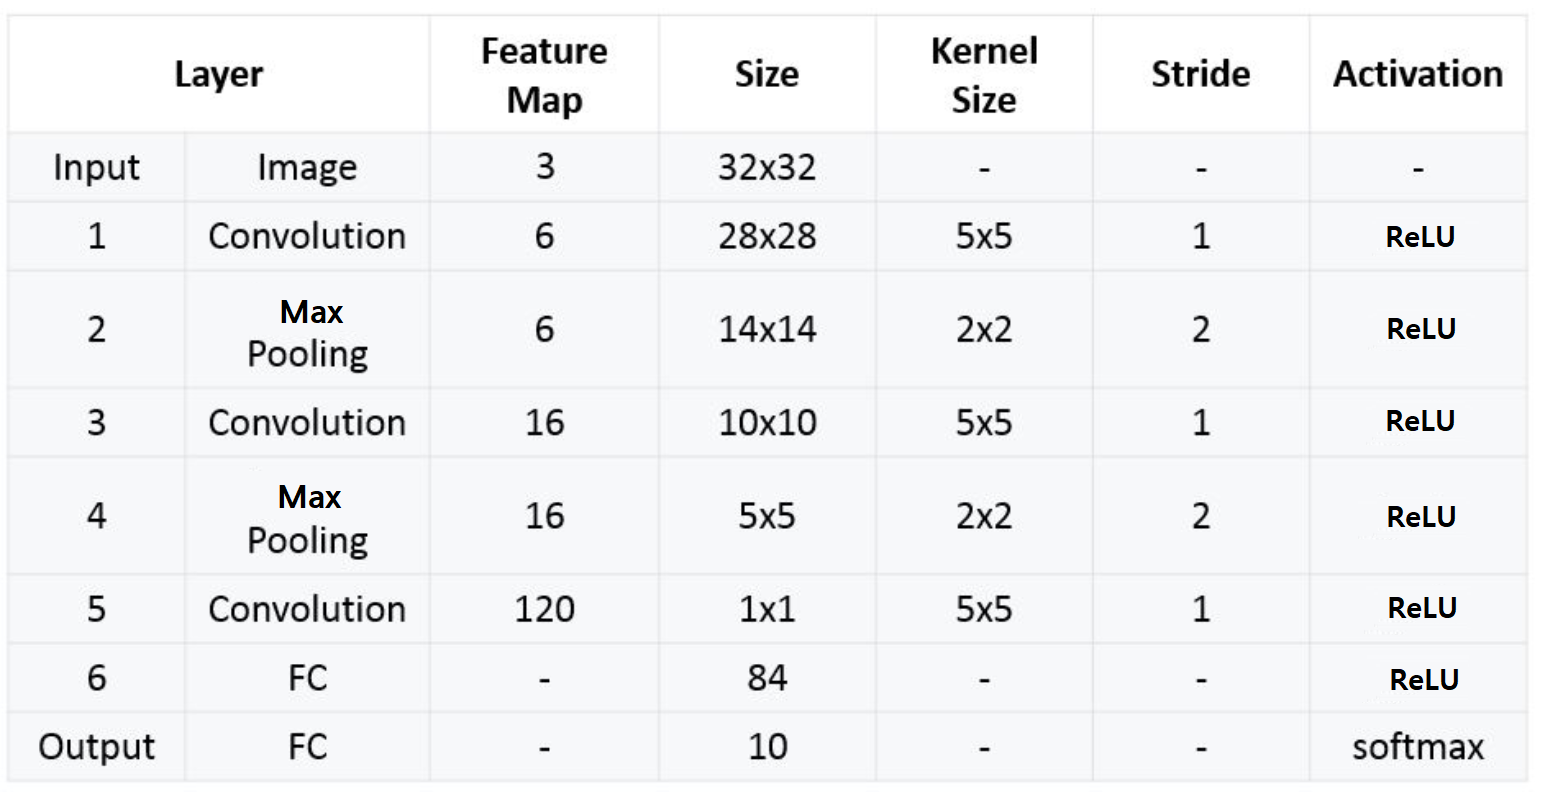

In [38]:
# 가이드라인 참고해서 CNN 모델 생성

############################### 2번 ######################################
class Net(torch.nn.Module):
  def __init__(self):
    super(Net,self).__init__() 
    self.layer1 = torch.nn.Sequential(
        torch.nn.Conv2d(3,6,kernel_size=5,stride=1,padding=0),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2,stride=2)
    )
    self.layer2 = torch.nn.Sequential(
        torch.nn.Conv2d(6,16,kernel_size=5,stride=1,padding=0),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2,stride=2)
    )

    self.f5 = torch.nn.Linear(16*5*5,120,bias=True)
    self.x5 = torch.nn.ReLU()
    
    self.f6 = torch.nn.Linear(120,84,bias=True)
    self.x6 = torch.nn.ReLU()
    
    self.output = torch.nn.Linear(84,10,bias=True)

  def forward(self,x):
    out = self.layer1(x)
    out = self.layer2(out)       
    out = out.view(out.size(0),-1) # batch x 1 x 1 x 120  
    out = self.f5(out)
    out = self.x5(out)
    out = self.f6(out)    
    out = self.x6(out)
    out = self.output(out) 

    return out
##########################################################################

In [39]:
model = Net().to(device)
print(model)

Net(
  (layer1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (f5): Linear(in_features=400, out_features=120, bias=True)
  (x5): ReLU()
  (f6): Linear(in_features=120, out_features=84, bias=True)
  (x6): ReLU()
  (output): Linear(in_features=84, out_features=10, bias=True)
)


In [40]:
# parameters
learning_rate = 0.001
training_epochs = 30

In [41]:
# MNIST는 다중분류 -> CrossEntropyLoss
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [42]:
# train
total_batch = len(train_loader)

for epoch in range(training_epochs):
    avg_cost = 0
    for X, Y in train_loader:
        X = X.to(device)
        Y = Y.to(device)

        ############## 3번 ############
        # H(x) 계산
        hypothesis = model(X)
        # cost 계산
        cost = criterion(hypothesis, Y)
        # cost로 H(x) 개선
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        ###############################
        avg_cost += cost / total_batch

    print('[Epoch: {:>2}] cost = {:>.9}'.format(epoch + 1, avg_cost))

[Epoch:  1] cost = 2.04454064
[Epoch:  2] cost = 1.78136599
[Epoch:  3] cost = 1.66339028
[Epoch:  4] cost = 1.5915302
[Epoch:  5] cost = 1.54394281
[Epoch:  6] cost = 1.5095365
[Epoch:  7] cost = 1.47898197
[Epoch:  8] cost = 1.43246162
[Epoch:  9] cost = 1.41053391
[Epoch: 10] cost = 1.38212979
[Epoch: 11] cost = 1.3602879
[Epoch: 12] cost = 1.33060193
[Epoch: 13] cost = 1.29973722
[Epoch: 14] cost = 1.28901434
[Epoch: 15] cost = 1.26010752
[Epoch: 16] cost = 1.24266541
[Epoch: 17] cost = 1.22729743
[Epoch: 18] cost = 1.20073295
[Epoch: 19] cost = 1.18706965
[Epoch: 20] cost = 1.16813004
[Epoch: 21] cost = 1.15452242
[Epoch: 22] cost = 1.1352309
[Epoch: 23] cost = 1.12642801
[Epoch: 24] cost = 1.11391139
[Epoch: 25] cost = 1.11012053
[Epoch: 26] cost = 1.08776438
[Epoch: 27] cost = 1.07591426
[Epoch: 28] cost = 1.07550812
[Epoch: 29] cost = 1.05374503
[Epoch: 30] cost = 1.04659593


In [43]:
accuracy = 0
total_batch = len(test_loader)

with torch.no_grad():
    model.eval()

    for X, Y in test_loader:
        X = X.to(device)
        Y = Y.to(device)
        
        prediction = model(X)
        correct_prediction = torch.argmax(prediction, 1) == Y
        accuracy += correct_prediction.float().mean()

print('Accuracy:', accuracy.item()/total_batch)

Accuracy: 0.5990866184234619
